# Lab 2

grupo
1. Diego Cordova 20212
2. Paola Contreras 20213
3. Paola de León 20361

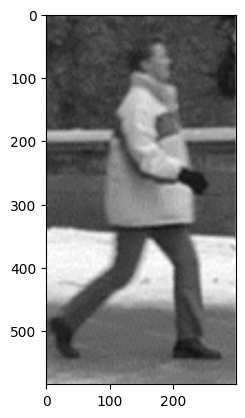

In [273]:
import matplotlib.pyplot as plt
import skimage as ski
import cv2 as cv
import numpy as np

def read_img(filepath):
    data = open(filepath, 'rb')
    img = plt.imread(data)
    return img

img = read_img('./person.png')
plt.imshow(img)

### 1. Implementar una funcion en Python que acepte una imagen a colores, y haga las siguientes transformaciones:
- conversion de RGB a escala de grises
- reescalado (resize) a un tamano (128k, 64k), (ratio 2:1).

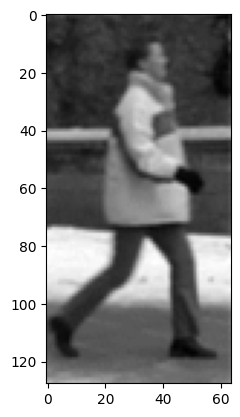

In [274]:
def parte1(img, k):
    '''
    funcion en Python que acepte una imagen a colores, y haga las siguientes transformaciones:
    - conversion de RGB a escala de grises
    - reescalado (resize) a un tamano (128k, 64k), (ratio 2:1).
    '''
    if k < 1 or k is None:
        raise Exception('K must be >= 1')

    # grayscale
    # gray_img = ski.color.rgb2gray(img)
    gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # resize
    resized_img = ski.transform.resize(gray_img, (128 * k, 64 * k))
    return resized_img
  
resized = parte1(img, 1)
plt.imshow(resized, cmap='gray')

### 2. Implementar una funci´on en Python que calcule la magnitud del y angulo del gradiente de una imagen en escala de grises. 
Internamente su algoritmo debe calcular las correlaciones Gx y Gy de la imagen con los filtros de Prewitt

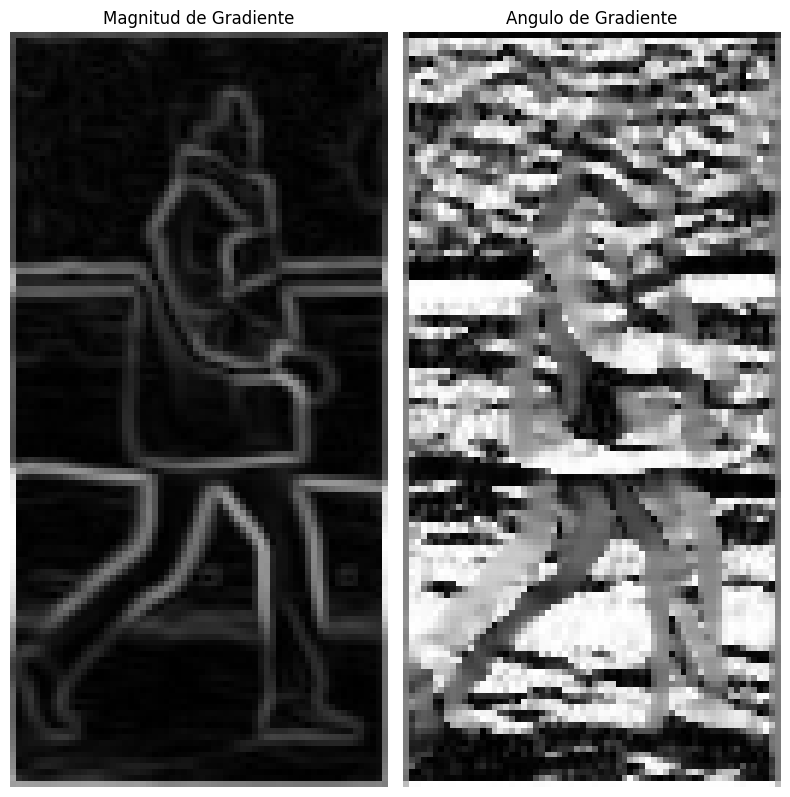

In [275]:
prewittX = np.array([
  [-1, -1, -1 ],
  [ 0,  0,  0 ],
  [ 1,  1,  1 ],
])

prewittY = np.array([
  [-1,  0, 1 ],
  [-1,  0, 1 ],
  [-1,  0, 1 ],
])

def apply_filter(I, filter):
    rows, cols = I.shape
    f_i, f_j = filter.shape

    result = np.zeros_like(I)
    padded_image = np.pad(I, ((1, 1), (1, 1)), mode='constant')

    for i in range(rows):
        for j in range(cols):
            region = padded_image[i:i+f_i, j:j+f_j]
            result[i, j] = np.sum(region * filter)

    return result

def gradient_magnitude_and_angle(image):
    Gx = apply_filter(image, prewittX)
    Gy = apply_filter(image, prewittY)

    # Magnitud
    magnitude = np.sqrt(np.square(Gx) + np.square(Gy))

    # Angulo
    angle = np.arctan2(-Gy, Gx)
    angle = np.absolute(angle) * 180 / np.pi

    return magnitude, angle

magnitude, angle = gradient_magnitude_and_angle(resized)

fig, axes = plt.subplots(1, 2, figsize=(8, 8), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(magnitude, cmap='gray')
ax[0].set_title('Magnitud de Gradiente')
ax[0].axis('off')

ax[1].imshow(angle, cmap='gray')
ax[1].set_title('Angulo de Gradiente')
ax[1].axis('off')

fig.tight_layout()
plt.show()

### 3. Implementar una funcion en Python que construya el stack de bloques de tamaño block size × block size
usando un stride de block size//2. En este caso, block size debe ser un par´ametro indicado por el usuario (se sugiere que sea un
m´ultiplo de 4, e.g. 4 × 4, 8 × 8, 16 × 16).

La entrada de la funci´on debe ser la imagen μ y θ obtenidas del gradiente, y su funci´on debe devolver dos stack o numpy
arrays de tama˜no M N ×block size × block size, uno para la magnitud y otros para el ´angulo del gradiente. Aqu´ı

In [276]:
def build_stack(magnitude, angle, block_size):
    rows, cols = magnitude.shape
    stride = block_size // 2
    M = rows // stride - 1
    N = cols // stride - 1

    # Inicializar los stacks de bloques
    magnitude_stack = np.zeros((M * N, block_size, block_size))
    angle_stack = np.zeros((M * N, block_size, block_size))

    # Construir los stacks de bloques
    block_index = 0
    for i in range(0, rows - block_size + 1, stride):
        for j in range(0, cols - block_size + 1, stride):
            magnitude_block = magnitude[i:i+block_size, j:j+block_size]
            angle_block = angle[i:i+block_size, j:j+block_size]
            magnitude_stack[block_index] = magnitude_block
            angle_stack[block_index] = angle_block
            block_index += 1

    return magnitude_stack, angle_stack, M, N

magnitude_stack, angle_stack, M, N = build_stack(magnitude, angle, 8)

print(magnitude_stack.shape)
print(angle_stack.shape)

(465, 8, 8)
(465, 8, 8)


### 4. Implementar una funcion en Python que construya el histograma de gradientes, a partir de los stacks de bloques μ y θ.
La construcci´on del histograma debe recibir un n´umero de bines n indicado por el usuario (se sugiere usar n = 9). Internamente
la funci´on deber´a calcular los centros de cada bin, y hacer un barrido de cada uno de los bloques en los stacks. Para cada
bloque, debe calcularse un vector (numpy array de tama˜no n) donde se guardar´a la informaci´on de su respectivo histograma.

La salida de la funci´on debe ser un numpy array H de tama˜no M N × n con la informaci´on de los cada histograma. Los
histogramas deber´an normalizarse utilizando la norma euclideana:

In [277]:
def build_gradient_histogram(magnitude_stack, angle_stack, n=9, epsilon=1e-10, M=0, N=0):
    # Calcular los bordes de cada bin
    bin_edges = np.linspace(0, 180, n + 1)
    # bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Inicializar el array H
    print("M", M)
    print("N", N)
    H = np.zeros((M * N, n))
    
    # Iterar sobre cada bloque en los stacks
    for i in range(M):
        for j in range(N):
            # Obtener el bloque de magnitud y ángulo
            magnitude_block = magnitude_stack[i * j]
            angle_block = angle_stack[i * j]
            
            # Calcular el histograma para el bloque
            histogram = np.histogram(angle_block, bins=bin_edges, weights=magnitude_block, density=False)[0]
            
            # Normalizar el histograma
            norm = np.linalg.norm(histogram) + epsilon
            H[i * N + j] = histogram / norm
    
    return H

H = build_gradient_histogram(magnitude_stack, angle_stack, n=9, M=M, N=N)
H.shape


M 31
N 15


(465, 9)

In [278]:
def build_gradient_histogram(magnitude_stack, angle_stack, n=9, M=0, N=0):
    num_blocks = magnitude_stack.shape[0]
    delta_theta = 180 // n
    H = np.zeros((M * N, n))
    
    # Iterar sobre cada bloque en los stacks
    for i in range(num_blocks):
        u = magnitude_stack[i].ravel()
        theta = angle_stack[i].ravel()
        hist = np.zeros(n)

        for k in range(len(u)):
            j = int((theta[k]/ delta_theta) - 0.5)
            Cj = delta_theta * (j + 0.5)
            Cj_pus_1 = delta_theta * (j + 1 + 0.5)

            hist[j] += abs(u[k] * ((Cj_pus_1 - theta[k]) / delta_theta))
            hist[(j+1) % 9] += abs(u[k] * ((theta[k] - Cj) / delta_theta))
        
        # Normalizacion
        hist = hist / np.sqrt((np.linalg.norm(hist)**2) + 1e-10)
        # hist = hist / np.sqrt(np.linalg.norm(hist)**2 + 1e-6)
        H[i] = hist
    
    return H

H = build_gradient_histogram(magnitude_stack, angle_stack, n=9, M=M, N=N)
H.shape


(465, 9)

### 5. Escribir una función en python que a cada bloque en el stack, convierta el histograma de ese bloque a un representaci´on visual.

Esta representaci´on visual ser´a una matriz de tama˜no block size × block size. Esta imagen se trabaja como una
imagen con fondo negro. Por cada ´ındice en el histograma de dicho bloque, i = 1, 2, . . . , n, se dibujar´a una l´ınea con ´angulo
en el centroide Ci del bin i, y de magnitud o intensidad igual al valor del histograma en el bin i.

Construir una imagen de direcciones que dibuje los histogramas visuales de cada bloque

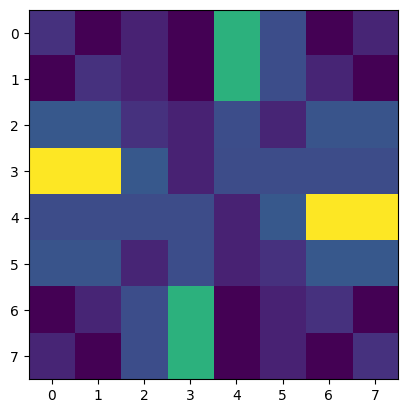

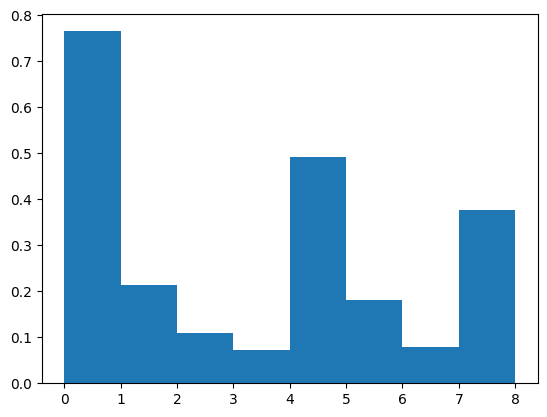

[0.04760911 0.05786694 0.04196984 0.16842512 0.96881764 0.10862809
 0.08116664 0.06882295 0.05023933]


In [279]:
def histogram_to_visual_representation(histogram, block_size):
    bin_centers = np.linspace(0, 180, len(histogram))
    visual_representation = np.zeros((block_size, block_size), dtype=np.uint8)
    center = block_size // 2
    
    # Dibujar una línea para cada bin del histograma
    for i in range(len(histogram)):
        angle_rad = np.deg2rad(bin_centers[i])

        if angle_rad < np.pi / 4:
            start_x = 0
            end_x = block_size - 1
            end_y = abs(int(center * (1 + np.tan(angle_rad))))
            start_y = block_size - 1 - end_y
        
        elif np.pi / 4 <= angle_rad < np.pi / 2:
            end_x = abs(int(center * (1 + (1/np.tan(angle_rad)))))
            start_x = block_size - 1 - end_x
            start_y = 0
            end_y = block_size - 1

        elif np.pi / 2 <= angle_rad < ((3 * np.pi) / 4):
            start_x = abs(int(center * (1 + (1/np.tan(np.pi - angle_rad)))))
            end_x = block_size - start_x - 1
            start_y = 0
            end_y = block_size - 1
        
        else:
            start_x = block_size - 1
            end_x = 0
            end_y = abs(int(center * (1 + np.tan(np.pi - angle_rad))))
            start_y = block_size - 1 - end_y

        try:
            # Dibujar la línea en la imagen
            cv.line(visual_representation, (start_x, start_y), (end_x, end_y), histogram[i] * 255, 1)
        except:
            print('> start:', (start_x, start_y))
            print('> end:', (end_x, end_y))
    
    return visual_representation


# import cv2
# import numpy as np

# def draw_line_through_center(image, angle_degrees, color=(255, 255, 255), thickness=1):
#     height, width = image.shape[:2]
#     center_x = width // 2
#     center_y = height // 2

#     # Convert angle from degrees to radians
#     angle_rad = np.deg2rad(angle_degrees)

#     # Calculate the direction vector of the line
#     direction_vector = np.array([np.cos(angle_rad), np.sin(angle_rad)])

#     # Generate points on the line that intersects with the image borders
#     point1 = np.array([center_x, center_y]) - (height + width) * direction_vector
#     point2 = np.array([center_x, center_y]) + (height + width) * direction_vector

#     # Draw the line on the image
#     cv2.line(image, (int(point1[0]), int(point1[1])), (int(point2[0]), int(point2[1])), color, thickness)
    
# def histogram_to_visual_representation(histogram, block_size):
#     bin_centers = np.linspace(0, 180, len(histogram))
#     visual_representation = np.zeros((block_size, block_size), dtype=np.uint8)
#     center = block_size // 2
    
#     # Normalize histogram values
#     hist_max = np.max(histogram)
#     if hist_max != 0:
#         histogram = histogram / hist_max

#     # Draw a line for each bin of the histogram
#     for i in range(len(histogram)):
#         draw_line_through_center(visual_representation, bin_centers[i], histogram[i] * 255)
#     return visual_representation

visual = histogram_to_visual_representation(H[0], 8)
plt.imshow(visual)
plt.show()
plt.hist(x=range(9), bins=range(9), weights=H[0])
plt.show()
print(H[105])

In [280]:
bin_centers = np.linspace(0, 180, len(H[0]))
np.deg2rad(bin_centers)

array([0.        , 0.39269908, 0.78539816, 1.17809725, 1.57079633,
       1.96349541, 2.35619449, 2.74889357, 3.14159265])

In [281]:
from PIL import Image
def completePiPeline(filepath, k, block_size, n):
    img = read_img(filepath)
    resized = parte1(img, k)
    magnitude, angle = gradient_magnitude_and_angle(resized)
	
    magnitude_stack, angle_stack, M, N = build_stack(magnitude, angle, block_size)
    H = build_gradient_histogram(magnitude_stack, angle_stack, n=n, M=M, N=N)
    
    visual_HOG = [histogram_to_visual_representation(H[i], block_size) for i in range(H.shape[0])]

    visual_grid = (resized.shape[0]//block_size, resized.shape[1]//block_size)
    visual_grid_y, visual_grid_x = visual_grid

    # Calculate the size of the final image
    final_height = visual_grid_y * block_size
    final_width = visual_grid_x * block_size

    # Create a blank image to render visual HOG
    visual_image = Image.new('L', (final_width, final_height))

    for i in range(visual_grid_y):
        for j in range(visual_grid_x):
            # Convert the visual HOG to a PIL image
            hog_image = Image.fromarray(visual_HOG.pop(0))

            # Paste the HOG image into the final image
            visual_image.paste(hog_image, (j * block_size, i * block_size))

    plt.imshow(visual_image)
    plt.show()

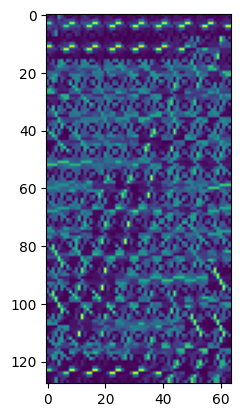

In [282]:
completePiPeline('./person.png', 1, 8, 9)

### 6

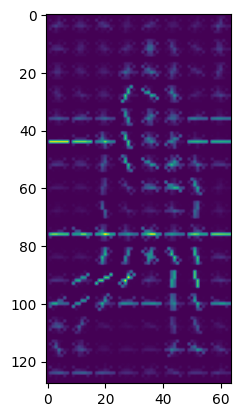

(3780,)


In [283]:
from skimage.feature import hog
I = read_img('./person.png')
I = parte1(I, 1)
fd, hogI = hog(I, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
plt.figure()
plt.imshow(hogI)
plt.show()
print(fd.shape)